<a href="https://colab.research.google.com/github/mayuneko-re/notebook/blob/master/colab/Ternary_Phase_Diagram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ternary Phase Diagramの計算

作成したPTフラッシュ計算コードを用いて，ある温度圧力での **Ternary Phase Diagram** を書いて見たいと思う．


**ライブラリのインポート**

複数の成分毎にフラッシュ計算を行うので、進捗がわかりやすいように`tqdm`もインポートする．

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

Ternary diagramプロット用には、'python-ternary'を使ってみる．

In [2]:
!pip install -q python-ternary
import ternary

用意したPTフラッシュ計算コードを、`wget`して、クラスをインポートする．

In [3]:
!rm mixture.py
!wget -nv https://raw.githubusercontent.com/mayuneko-re/notebook/master/py/mixture.py
from mixture import Components, Mixture

rm: cannot remove 'mixture.py': No such file or directory
2019-11-16 12:20:50 URL:https://raw.githubusercontent.com/mayuneko-re/notebook/master/py/mixture.py [13005/13005] -> "mixture.py" [1]


## 成分の設定

Mixtureを構成する成分を設定する．今回は、CO2, C4, C10とする．

In [0]:
# Set components which you need.
butane = Components(name='butane', Pc=37.996875, Tc=425.2, omega=0.193)
decane = Components(name='decane', Pc=21.0756, Tc=617.6, omega=0.49)
co2 = Components(name='co2', Pc=73.7646, Tc=304.2, omega=0.225)

feed = [co2, butane, decane]

kik = np.array([[0     , 0.1300, 0.1020],
                [0.1300, 0     , 0     ],
                [0.1020, 0     , 0     ]
                ])

各成分のモル比を設定し、リストに格納．予備的な検討から、今回の系ではCO2のモル濃度がおよそ0.6以上の領域で二相状態となるようなので、計算量を減らすために、CO2のモル濃度が0.5以上の部分だけを対象としている．

In [5]:
Z1 = np.linspace(0.5, 1  , 51,endpoint=True) # CO2
Z2 = np.linspace(0  , 0.4, 41,endpoint=True) # C4

import itertools
Zi_list = list(itertools.product(Z1, Z2))
Zi_list = np.array([[z[0],z[1],1-z[0]-z[1]] for z in Zi_list if z[0]+z[1]<=0.999])

Zi_list.shape

(1230, 3)

というわけで、この1230ケースでPTフラッシュ計算を行い、平衡状態を評価していく．

## PTフラッシュ計算

各Mixtureに対して、PTフラッシュを実施し、リストに格納する．

In [6]:
# Pressure
P = 1250/14.5038 # 1250psia

# Temperature
T = (160-32)*5/9+273.15 # 160degF

ml = [] # mixture list

# PT Flash Calculation
for Zi in tqdm(Zi_list):
    m = Mixture(feed) # Make instance
    m.set_BIPs(kik) # Set binary interaction parameters
    m.set_composition(Zi) # Set composition
    m.PT_flash(P,T) # PT flash calculation
    ml.append(m) # Store into mixture list

## Ternary Phase Diagramの作成

二相状態のときのV値をもとに、Ternary phase diagramの作成する．また、V値のコンターとしてQuality lineをプロットすることにする．

In [0]:
# Get vapor-liquid equilibrium points
ml_twophase = [m for m in ml if m.phase=='two-phase']

# (right corner, top corner, left corner) for ternary plot
v = [(m.Yi[1],m.Yi[0],m.Yi[2]) for m in ml_twophase] # Vapor line
l = [(m.Xi[1],m.Xi[0],m.Xi[2]) for m in ml_twophase] # Liquid line

# Get Quality lines using matplotlib's contour plot
ml_tmp = [m for m in ml if ~np.isnan(m.V)]
V = [m.V for m in ml_tmp]
z1 = [m.Zi[0] for m in ml_tmp]
z2 = [m.Zi[1] for m in ml_tmp]

cs = plt.tricontour(z1,z2,V,levels=[0.2,0.4,0.6,0.8]) # cs: matplotlib.tri.tricontour.TriContourSet
plt.close()

プロットしてみる．

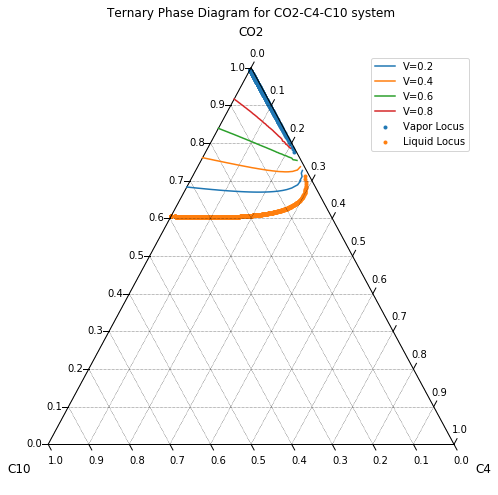

In [8]:
## Boundary and Gridlines
figure, tax = ternary.figure(scale=1)
figure.set_size_inches(8, 8)

# Draw Boundary and Gridlines
tax.boundary(linewidth=1)
tax.gridlines(color="black", multiple=0.1)

# Set Axis labels and Title
fontsize = 12
tax.set_title("Ternary Phase Diagram for CO2-C4-C10 system\n\n", fontsize=fontsize)
tax.right_corner_label("C4", fontsize=fontsize)
tax.top_corner_label("CO2", fontsize=fontsize)
tax.left_corner_label("C10", fontsize=fontsize)

# Set ticks
tax.ticks(axis='lbr', linewidth=1, multiple=0.1, offset=0.015, tick_formats="%.1f", clockwise=True)

# Plot the data
tax.scatter(v, marker='.', label='Vapor Locus')
tax.scatter(l, marker='.', label='Liquid Locus')

# Plot the Quality lines
cl = cs.collections
for i,c1 in enumerate(cl):
    cc = c1.get_paths()[0].vertices
    cc = [[c[1],c[0],1-c[0]-c[1]] for c in cc]
    tax.plot(cc, label='V='+str(cs.get_array()[i]))

tax.legend()

# Remove default Matplotlib Axes
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')

ternary.plt.show()

今回の温度圧力条件でのCO2-C4-C10系の相平衡状態を示している．
CO2のモル分率がおよそ0.6以上となる範囲で二相状態となっている．また、二相状態のときの気相側にはC10がほとんど含まれていない．
一方、CO2のモル分率が0.6以下の範囲では、この系は常に一相状態となった．

論文とほぼ同じ形となったので良しとする．

*End of notebook...*